
# Trabalho de Sistemas Inteligentes para a Bioinformática

Trabalho realizado no âmbito da unidade curricular de Sistemas Inteligentes para a Bioinformática.

Grupo constituído por:

    - Angelina Eiras PG42861
    - Carina Gonçalves PG45466
    - Rute Castro PG45475
    - Sónia Carvalho PG42882


# A alterar:

    - Poucos descritores: gerar mais com o propythia
    - Separar o x do y antes de fazer standardscaler e usar o y sem alterar os valores 
    - Retirar valores de pH maiores que 14
    - Fazer análise com base na literatura, exemplo, ponto em que a termoestabilidade representa a estabilidade etc
    - Aumentar número de features, 
    - não e preciso normalizar (podemos fazer scale e apenas no X), 
    - machine learning com regressão (tm variável continua)

Para a utilização deste notebook é necessário proceder às seguintes instalações:

In [92]:
# pip install git+https://github.com/jcapels/propythia.git@fix_dependencies
#ou download do ficheiro em formato zip
# pip install propythia.zip --user
# pip install seaborn
# pip install --upgrade pip
# pip install tensorflow==2.11.0
# pip install keras
# pip install umap-learn[plot]
# pip install bio-embeddings[all]
# pip install plotly

In [93]:
import pandas as pd
import scipy.cluster.hierarchy
import seaborn as sn
import numpy as np
from tensorflow import keras
from keras.optimizers.schedules import *
from propythia import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import r_regression
from scipy import stats
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind
from statsmodels.stats.weightstats import ztest as ztest
import statsmodels.api as statsmodels
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import re
import random
import requests as r
from Bio import SeqIO
from io import StringIO
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.optimizers.schedules import *

from propythia import *
from propythia.protein_descriptores import ProteinDescritors

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import auc, roc_curve, matthews_corrcoef, f1_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss, hinge_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, SelectPercentile

import matplotlib.pyplot as plt

## Exploração inicial

Nesta secção são apresentados os dados provenientes do desafio Kaggle (https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction).

Os datasets abordam o tema de enzimas que são proteínas que atuam como catalisadores nas reações químicas dos organismos vivos.

O objetivo do trabalho é prever a termoestabilidade de variantes enzimáticas, uma vez que compreender e prever com precisão a estabilidade da proteína é um problema fundamental na biotecnologia. Melhorias na estabilidade da enzima podem reduzir os custos e aumentar a velocidade que os cientistas podem iterar nos conceitos.

Os dados de termoestabilidade (temperatura de fusão) foram medidos experimentalmente e incluem sequências naturais, bem como sequências modificadas com mutações únicas ou múltiplas nas sequências naturais.



------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------

## Pré-processamento

Ler os datasets provenientes do desafio

In [94]:
#train = pd.read_csv("C:/Users/sonia/Desktop/SIB_v1/kag/train.csv", delimiter=',')
#updates = pd.read_csv("C:/Users/sonia/Desktop/SIB_v1/kag/train_updates_20220929.csv")

In [95]:
train = pd.read_csv('train.csv', delimiter = ',')
updates = pd.read_csv('train_updates_20220929.csv', delimiter = ',')

In [96]:
print(train.shape)
train.head()

(31390, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [97]:
print(updates.shape)
updates.head()


(2434, 5)


,seq_id,protein_sequence,pH,data_source,tm
0,69,NaN,NaN,NaN,NaN
1,70,NaN,NaN,NaN,NaN
2,71,NaN,NaN,NaN,NaN
3,72,NaN,NaN,NaN,NaN
4,73,NaN,NaN,NaN,NaN


Juntar dataset de treino com os updates dados pela competição

In [98]:
#colunas para fazer o update
col_to_update = ['protein_sequence', 'pH', 'tm']

#seq_id update
to_update_id = list(updates[~updates.protein_sequence.isna()].seq_id)

#faz o update só nas linhas que são necessarias
updates = updates[updates.seq_id.isin(to_update_id)].set_index('seq_id')

#update dos valores no dataset de treino
train.loc[to_update_id, col_to_update] = updates[col_to_update].values

#verificar se está com os updates
pd.concat([train[train.seq_id.isin(to_update_id)].set_index('seq_id'), updates], axis = 1)

#nao precisamos dos links - drop do data_source
train.drop(['data_source'], axis=1, inplace=True)

print(train.shape)
train.head()


(31390, 4)


,seq_id,protein_sequence,pH,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


### Gerar descritores

Para gerar descritores foi utilizado o propythia, desenvolvido na Universidade do Minho.
Através da sua utilização, foi possível obter descritores físico-químicos que vão ser utilizados para o resto do trabalho.

In [134]:
#obter os descritores
descriptors_df = ProteinDescritors(dataset= train ,  col= 'protein_sequence')
descriptors_df.dataset

idxs = train[train.isna().any(axis=1)].index
print(f"Number of rows still containing NaNs: {len(idxs)}")
train.drop(index=idxs, inplace=True)
idxs = train[train.isna().any(axis=1)].index
print(f"Number of rows still containing NaNs: {len(idxs)}")
train.to_csv("train_nanFREE.csv")

Number of rows still containing NaNs: 0
Number of rows still containing NaNs: 0


In [133]:
# tamanho das sequencias
tamanho = descriptors_df.get_lenght(n_jobs=4)
tamanho.min()

protein_sequence    AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...
length                                                            5.0
dtype: object

In [101]:
# quantidades de aminoácidos
descriptors_df.get_aa_comp(n_jobs=4)

,protein_sequence,A,R,N,D,C,E,Q,G,H,...,L,K,M,F,P,S,T,W,Y,V
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,13.196,7.331,1.466,3.812,0.293,8.798,1.760,11.144,0.880,...,10.850,4.692,2.346,3.812,5.279,3.226,4.106,1.173,0.880,10.850
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,9.790,10.490,2.098,3.497,0.000,18.182,7.692,6.294,1.399,...,8.042,6.643,0.699,2.098,2.797,4.895,4.196,1.049,1.049,4.545
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,10.060,6.237,3.018,5.433,1.811,6.439,5.030,13.078,2.213,...,3.622,7.847,1.207,4.225,4.024,6.640,6.036,0.604,3.219,6.036
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.547,3.774,3.396,7.170,1.887,10.943,3.396,6.038,2.642,...,10.566,6.415,0.755,4.528,6.038,6.038,7.170,1.132,1.509,5.283
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,5.927,4.342,4.480,5.376,0.965,5.376,3.722,5.789,2.757,...,7.167,4.686,2.136,2.205,8.822,10.200,8.270,1.103,3.239,8.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28718,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,6.011,7.650,4.372,6.922,2.186,5.647,4.372,9.290,2.732,...,8.379,5.829,2.368,3.279,4.554,6.011,3.279,2.368,3.279,7.650
28719,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.889,5.330,4.051,4.478,1.066,6.183,3.412,5.757,4.691,...,10.021,4.264,2.985,4.691,4.051,7.889,5.544,1.066,2.985,7.249
28720,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,10.156,2.344,3.906,5.469,0.781,5.469,6.250,8.594,1.562,...,4.688,6.250,5.469,5.469,4.688,7.812,4.688,3.125,3.125,5.469
28721,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.926,4.216,4.216,5.734,0.843,6.071,2.024,8.769,1.855,...,7.589,5.902,4.384,3.879,5.228,8.600,5.396,0.506,3.035,8.094


Descritores físico-químicos gerados:
  
length, charge, chargedensity, formulaC, formulaH, formulaN, formulaO, formulaS, tot, hydrogen, single, double, MW_modlamp, Gravy, Aromacity, IsoelectricPoint, Instability_index, SecStruct_helix, SecStruct_turn, SecStruct_sheet, Molar_extinction_coefficient_reduced, Molar_extinction_coefficient_oxidized, aliphatic_index, bomanindex, hydrophobic_ratio.

In [102]:
# all_descriptors = descriptors_df.get_all_physicochemical(ph=7, amide=False, n_jobs=4)
# all_descriptors.to_csv('descriptors.csv')
# all_descriptors

------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------

### Importar dados físico-químicos

Estes dados são provenientes do código anterior, onde foram colocadas todas as características físico-químicas num único ficheiro csv, de maneira a facilitar e agilizar o processo.

In [103]:
dataset = pd.read_csv("descriptors.csv", delimiter=';')
#dataset = pd.read_csv("C:/Users/sonia/Desktop/SIB_v1/kag/descriptors.csv", delimiter=';')

# shape e data types
print(dataset.shape, dataset.dtypes)

(28739, 30) Unnamed: 0                                 int64
seq_id                                     int64
protein_sequence                          object
pH                                       float64
length                                   float64
charge                                   float64
chargedensity                            float64
formulaC                                   int64
formulaH                                   int64
formulaN                                   int64
formulaO                                   int64
formulaS                                   int64
tot                                        int64
hydrogen                                   int64
single                                     int64
double                                     int64
MW_modlamp                               float64
Gravy                                    float64
Aromacity                                float64
IsoelectricPoint                         float64
Instabil

In [104]:
dataset.head()

,Unnamed: 0,seq_id,protein_sequence,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,...,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio,tm
0,0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,341.0,-1.732,-0.000048,1622,2623,447,...,28.389736,0.316716,0.211144,0.351906,26470,26470,102.991202,1.020440,0.454545,75.7
1,1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,286.0,-12.537,-0.000382,1385,2224,412,...,65.108392,0.213287,0.160839,0.367133,20970,20970,72.062937,3.240490,0.297203,50.5
2,2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,497.0,11.513,0.000215,2290,3559,669,...,35.089336,0.209256,0.267606,0.213280,40340,40840,54.245473,2.168934,0.301811,40.5
3,3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,265.0,-20.606,-0.000699,1293,2006,338,...,50.502264,0.267925,0.215094,0.298113,22460,22710,78.792453,1.902415,0.343396,47.2
4,4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,1451.0,-21.900,-0.000138,6948,10869,1869,...,45.668808,0.271537,0.292901,0.206065,158030,158905,77.746382,1.684390,0.318401,49.5


sumarização de valores estatísticos gerais

In [105]:
dataset.describe()
#as variáveis têm valores em gamas muito diferentes, 
#por isso será preciso fazer normalização dos dados


,Unnamed: 0,seq_id,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,...,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio,tm
count,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,...,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000,28739.000000
mean,14369.000000,15545.248234,6.951551,461.012457,-5.313969,-0.000062,2258.002679,3541.273357,609.005915,711.923240,...,40.477407,0.296239,0.226101,0.267736,48028.957862,48425.448693,85.234561,1.683476,0.370748,49.350659
std,8296.379029,9224.897566,0.951033,430.562526,18.652624,0.000334,2085.418633,3274.813811,568.801797,685.215374,...,11.352726,0.044597,0.043856,0.048460,47705.473385,48142.209405,14.395127,0.551643,0.049421,13.731283
min,0.000000,0.000000,1.990000,5.000000,-903.437000,-0.002708,22.000000,40.000000,8.000000,7.000000,...,-7.383333,0.022727,0.030769,0.000000,0.000000,0.000000,0.000000,-1.661429,0.045977,0.000000
25%,7184.500000,7440.500000,7.000000,219.000000,-9.853500,-0.000232,1086.000000,1700.000000,290.000000,334.000000,...,33.358050,0.274854,0.199166,0.237401,19940.000000,20190.000000,77.061510,1.386256,0.342857,42.300000
50%,14369.000000,15188.000000,7.000000,356.000000,-3.347000,-0.000082,1751.000000,2745.000000,469.000000,541.000000,...,39.665278,0.299758,0.222222,0.265957,35300.000000,35450.000000,85.596817,1.660613,0.372727,48.000000
75%,21553.500000,23694.500000,7.000000,544.000000,3.029000,0.000086,2687.000000,4182.000000,718.000000,833.000000,...,46.754319,0.319873,0.246106,0.293698,60390.000000,61030.000000,94.006806,1.981683,0.399216,53.500000
max,28738.000000,31389.000000,64.900000,8798.000000,396.696000,0.002890,43327.000000,68830.000000,11684.000000,14709.000000,...,141.642748,0.632653,0.747126,0.579832,920160.000000,928160.000000,194.285714,5.281972,0.637681,130.000000


Valores omissos

In [106]:
#confirmar que não há dados omissos 
dataset.isnull().sum()

Unnamed: 0                               0
seq_id                                   0
protein_sequence                         0
pH                                       0
length                                   0
charge                                   0
chargedensity                            0
formulaC                                 0
formulaH                                 0
formulaN                                 0
formulaO                                 0
formulaS                                 0
tot                                      0
hydrogen                                 0
single                                   0
double                                   0
MW_modlamp                               0
Gravy                                    0
Aromacity                                0
IsoelectricPoint                         0
Instability_index                        0
SecStruct_helix                          0
SecStruct_turn                           0
SecStruct_s

perceber se há colunas com todos os valores iguais (variância = zero)

In [107]:
# criar um threshold e eliminar columas com variancia zero
variances = dataset.var(axis=0)

for column in dataset.columns:
    if variances.get(column) == 0.0:
        print("removed",column)
        dataset = dataset.drop(column, axis=1)
dataset.var(axis=0)


removed tot
removed hydrogen
removed single
removed double


Unnamed: 0                               6.882990e+07
seq_id                                   8.509874e+07
pH                                       9.044631e-01
length                                   1.853841e+05
charge                                   3.479204e+02
chargedensity                            1.117612e-07
formulaC                                 4.348971e+06
formulaH                                 1.072441e+07
formulaN                                 3.235355e+05
formulaO                                 4.695201e+05
formulaS                                 3.406342e+02
MW_modlamp                               2.310338e+09
Gravy                                    1.018051e-01
Aromacity                                6.410086e-04
IsoelectricPoint                         2.863506e+00
Instability_index                        1.288844e+02
SecStruct_helix                          1.988920e-03
SecStruct_turn                           1.923389e-03
SecStruct_sheet             

In [108]:
# eliminar linhas duplicadas, drop das duas colunas para ser possível fazer o pre porcessamento dos dados
df = dataset.drop_duplicates(subset = "seq_id")
df = df.drop(columns=['seq_id', 'protein_sequence'], axis=1)
df.columns

Index(['Unnamed: 0', 'pH', 'length', 'charge', 'chargedensity', 'formulaC',
       'formulaH', 'formulaN', 'formulaO', 'formulaS', 'MW_modlamp', 'Gravy',
       'Aromacity', 'IsoelectricPoint', 'Instability_index', 'SecStruct_helix',
       'SecStruct_turn', 'SecStruct_sheet',
       'Molar_extinction_coefficient_reduced',
       'Molar_extinction_coefficient_oxidized', 'aliphatic_index',
       'bomanindex', 'hydrophobic_ratio', 'tm'],
      dtype='object')

Visualização rápida de histograma de todas as variáveis

Podemos ver que a maior parte não parece seguir distribuição normal

array([[<AxesSubplot: title={'center': 'Unnamed: 0'}>,
        <AxesSubplot: title={'center': 'pH'}>,
        <AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'charge'}>,
        <AxesSubplot: title={'center': 'chargedensity'}>],
       [<AxesSubplot: title={'center': 'formulaC'}>,
        <AxesSubplot: title={'center': 'formulaH'}>,
        <AxesSubplot: title={'center': 'formulaN'}>,
        <AxesSubplot: title={'center': 'formulaO'}>,
        <AxesSubplot: title={'center': 'formulaS'}>],
       [<AxesSubplot: title={'center': 'MW_modlamp'}>,
        <AxesSubplot: title={'center': 'Gravy'}>,
        <AxesSubplot: title={'center': 'Aromacity'}>,
        <AxesSubplot: title={'center': 'IsoelectricPoint'}>,
        <AxesSubplot: title={'center': 'Instability_index'}>],
       [<AxesSubplot: title={'center': 'SecStruct_helix'}>,
        <AxesSubplot: title={'center': 'SecStruct_turn'}>,
        <AxesSubplot: title={'center': 'SecStruct_sheet'}>,
        <

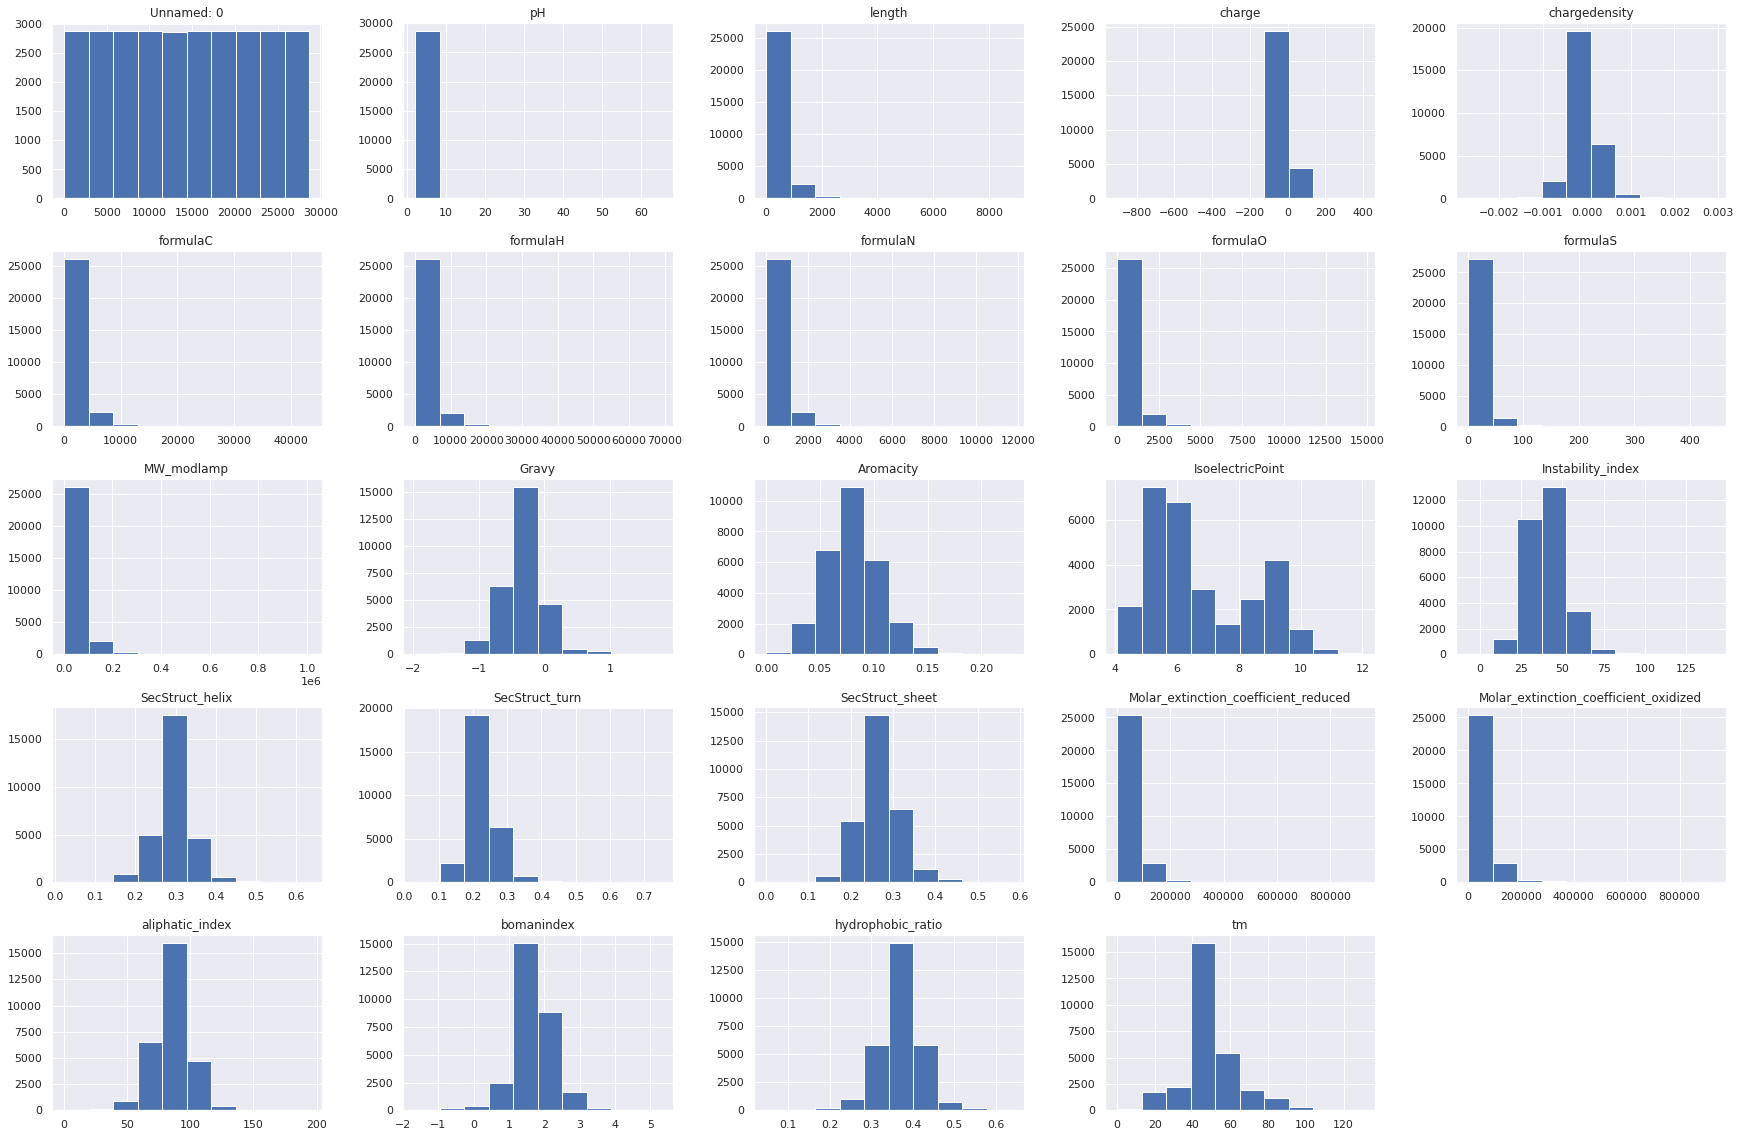

In [109]:
df.hist(figsize=(30,20))


Normalização dos dados através do Standard Scaler 

In [110]:
from sklearn.preprocessing import StandardScaler
#fazer normalização dos dados de X
data = StandardScaler().fit(df)
data_st = data.transform(df)

#sumariar os dados transformados (atenção que agora é array numpy e não panda dataframe)
np.set_printoptions(precision = 3)

#converter de novo a panda dataframe 
data_scale =  pd.DataFrame(data_st, index =df.index , columns = df.columns)
data_scale

#sumariar estatísticas
data_scale.describe()

,Unnamed: 0,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,...,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio,tm
count,28739.000000,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,...,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04,2.873900e+04
mean,0.000000,1.157083e-16,4.549214e-17,-1.433991e-17,-1.186751e-17,3.263567e-17,2.818535e-17,5.884310e-17,-3.189395e-17,-2.126263e-17,...,-3.678930e-16,1.190707e-15,1.780127e-16,4.351422e-16,-4.351422e-17,-5.735966e-17,1.226804e-15,3.105333e-16,2.991603e-16,-4.747006e-16
std,1.000017,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.731991,-5.217105e+00,-1.059127e+00,-4.815079e+01,-7.917032e+00,-1.072227e+00,-1.069170e+00,-1.056636e+00,-1.028779e+00,-9.462417e-01,...,-4.215866e+00,-6.133037e+00,-4.453971e+00,-5.524987e+00,-1.006798e+00,-1.005901e+00,-5.921174e+00,-6.063638e+00,-6.571620e+00,-3.594094e+00
25%,-0.865995,5.094425e-02,-5.620941e-01,-2.433765e-01,-5.111033e-01,-5.620085e-01,-5.622626e-01,-5.608482e-01,-5.515489e-01,-5.669603e-01,...,-6.271164e-01,-4.795361e-01,-6.141835e-01,-6.260056e-01,-5.888097e-01,-5.865111e-01,-5.677751e-01,-5.388008e-01,-5.643644e-01,-5.134831e-01
50%,0.000000,5.094425e-02,-2.439002e-01,1.054545e-01,-6.170094e-02,-2.431222e-01,-2.431550e-01,-2.461461e-01,-2.494489e-01,-2.418620e-01,...,-7.153732e-02,7.890323e-02,-8.844907e-02,-3.671070e-02,-2.668285e-01,-2.695280e-01,2.516559e-02,-4.144638e-02,4.004624e-02,-9.836538e-02
75%,0.865995,5.094425e-02,1.927455e-01,4.472890e-01,4.404803e-01,2.057164e-01,1.956563e-01,1.916238e-01,1.767019e-01,1.916024e-01,...,5.529087e-01,5.299474e-01,4.561483e-01,5.357371e-01,2.591161e-01,2.618237e-01,6.094005e-01,5.405891e-01,5.760343e-01,3.021868e-01
max,1.731991,6.093319e+01,1.936335e+01,2.155284e+01,8.830634e+00,1.969375e+01,1.993697e+01,1.947108e+01,2.042762e+01,2.305685e+01,...,8.911261e+00,7.543492e+00,1.188045e+01,6.440378e+00,1.828189e+01,1.827398e+01,7.575692e+00,6.523347e+00,5.401286e+00,5.873504e+00


verificar a normalidade da termoestabilidade após StandardScaler

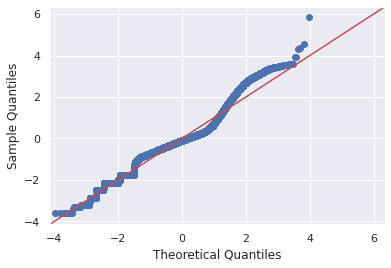

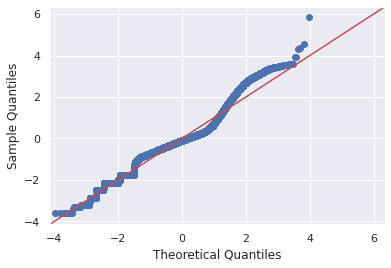

In [111]:
statsmodels.qqplot(data_scale.tm, dist = stats.norm, line = '45', ax = None)


Distribuição da termoestabilidade

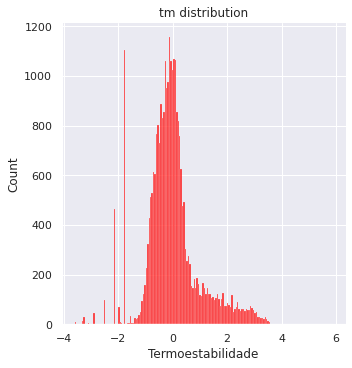

In [112]:

sn.displot(data = data_scale, x = 'tm', color = 'red')
plt.xlabel('Termoestabilidade')
plt.title('tm distribution')
plt.show()


Correlação entre as variaveis

In [113]:
corr_matrix = data_scale.corr()
#corr_matrix

#transformar em pandas dataframe (mais facil visualizaçao)
corr_dataframe = pd.DataFrame(corr_matrix)
corr_dataframe

,Unnamed: 0,pH,length,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,...,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,Molar_extinction_coefficient_reduced,Molar_extinction_coefficient_oxidized,aliphatic_index,bomanindex,hydrophobic_ratio,tm
Unnamed: 0,1.000000,-0.019184,-0.016976,0.022823,0.018067,-0.016701,-0.015960,-0.015623,-0.016501,-0.018040,...,-0.039385,0.024489,-0.021122,-0.017594,-0.023570,-0.023780,0.028664,0.008217,0.004314,0.003711
pH,-0.019184,1.000000,0.012413,-0.026170,-0.127817,0.013363,0.012447,0.010793,0.010698,0.001170,...,0.067457,0.024607,0.040893,0.025240,-0.002451,-0.002757,0.008056,-0.053055,0.001705,0.004650
length,-0.016976,0.012413,1.000000,-0.509214,-0.133545,0.998779,0.998725,0.998537,0.998140,0.875966,...,0.221563,-0.145833,0.130881,-0.020341,0.836082,0.838196,-0.095124,0.111823,-0.150437,-0.076283
charge,0.022823,-0.026170,-0.509214,1.000000,0.611052,-0.506844,-0.501853,-0.492257,-0.533917,-0.420126,...,-0.050752,0.047601,0.057354,-0.130251,-0.424229,-0.425497,0.026766,-0.052645,0.057371,0.049609
chargedensity,0.018067,-0.127817,-0.133545,0.611052,1.000000,-0.132815,-0.127395,-0.118161,-0.148362,-0.103832,...,-0.030650,-0.040692,0.076594,-0.213483,-0.116153,-0.116179,-0.036021,0.058152,-0.012935,-0.011778
formulaC,-0.016701,0.013363,0.998779,-0.506844,-0.132815,1.000000,0.999620,0.998124,0.996641,0.874882,...,0.217614,-0.121156,0.110355,-0.018321,0.848774,0.850696,-0.084006,0.109832,-0.142218,-0.075088
formulaH,-0.015960,0.012447,0.998725,-0.501853,-0.127395,0.999620,1.000000,0.998399,0.996719,0.872841,...,0.218662,-0.124754,0.104192,-0.009292,0.838114,0.840072,-0.076246,0.113364,-0.137758,-0.073827
formulaN,-0.015623,0.010793,0.998537,-0.492257,-0.118161,0.998124,0.998399,1.000000,0.997166,0.873181,...,0.233875,-0.155008,0.120267,-0.019048,0.836195,0.838254,-0.103960,0.140228,-0.163374,-0.072777
formulaO,-0.016501,0.010698,0.998140,-0.533917,-0.148362,0.996641,0.996719,0.997166,1.000000,0.867383,...,0.231892,-0.166361,0.124727,-0.025078,0.827235,0.829298,-0.115624,0.143394,-0.177351,-0.085848
formulaS,-0.018040,0.001170,0.875966,-0.420126,-0.103832,0.874882,0.872841,0.873181,0.867383,1.000000,...,0.205084,-0.127173,0.103052,-0.066369,0.765848,0.771405,-0.113601,0.053105,-0.069374,-0.118445


Heatmap da correlação

As variaveis mais correlacionadas são as formulaC, formulaN, formulaO formulaS, com o tamanho, a carga, o Molar_extinction_coefficient_reduced e o Molar_extinction_coefficient_oxidized

<AxesSubplot: >

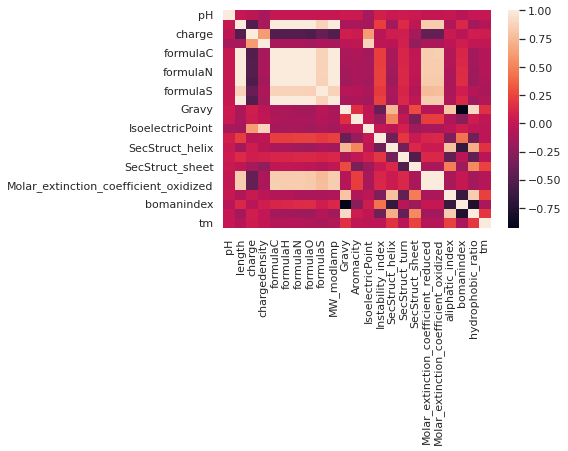

In [114]:
sn.heatmap(corr_matrix.iloc[1:,1:], annot=False)

Clustermap da correlação

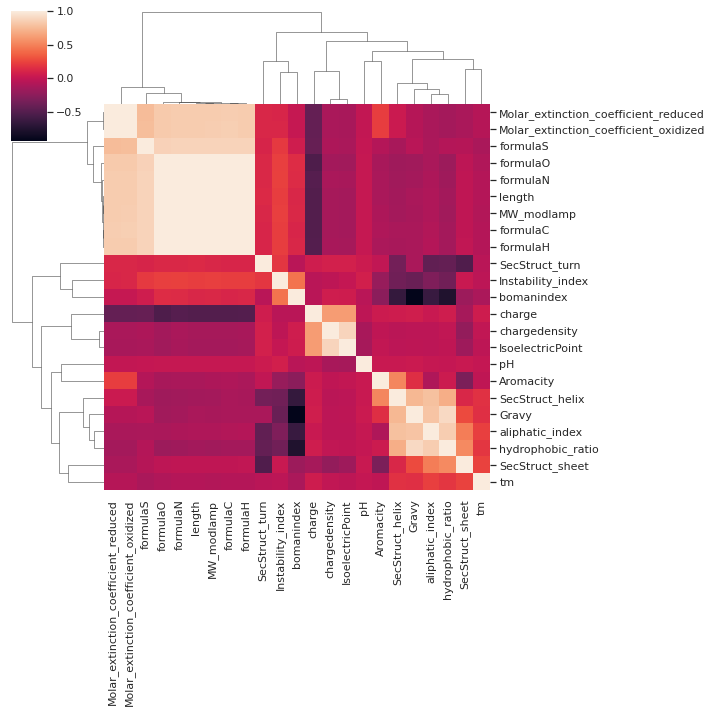

In [115]:
#clustermap / clustering hierárquico
sn.clustermap(corr_matrix.iloc[1:,1:])


Seleção de features que têm uma correlação muito elevada, superior a 0.8

Resultado: {'bomanindex', 'formulaH', 'formulaO', 'hydrophobic_ratio', 'Molar_extinction_coefficient_reduced', 'formulaC', 'IsoelectricPoint', 'formulaN', 'formulaS', 'Molar_extinction_coefficient_oxidized', 'MW_modlamp'}


In [116]:
correlated_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features))
print(correlated_features)

11
{'formulaH', 'formulaN', 'Molar_extinction_coefficient_oxidized', 'bomanindex', 'Molar_extinction_coefficient_reduced', 'formulaC', 'formulaO', 'formulaS', 'MW_modlamp', 'hydrophobic_ratio', 'IsoelectricPoint'}


Dada a elevada correlação entre as features anteriores, decidimos retira-las da análise seguinte de maneira a obter melhores resultados.

features retiradas: 


In [117]:
drop_features = {'Molar_extinction_coefficient_reduced', 'Molar_extinction_coefficient_oxidized', 'formulaC', 'hydrophobic_ratio', 'formulaO', 'IsoelectricPoint', 'formulaN', 'MW_modlamp', 'formulaH', 'formulaS', 'bomanindex'}
#data_scale.columns # KeyError: "['formulaC', 'formulaS', 'formulaO', 'formulaH', 'formulaN'] not found in axis"
data_scale.drop(labels = correlated_features, axis = 1, inplace = True)


Ficamos apenas com as seguintes colunas: 

In [118]:
data_scale.columns

Index(['Unnamed: 0', 'pH', 'length', 'charge', 'chargedensity', 'Gravy',
       'Aromacity', 'Instability_index', 'SecStruct_helix', 'SecStruct_turn',
       'SecStruct_sheet', 'aliphatic_index', 'tm'],
      dtype='object')

Correlação das features finais

<AxesSubplot: >

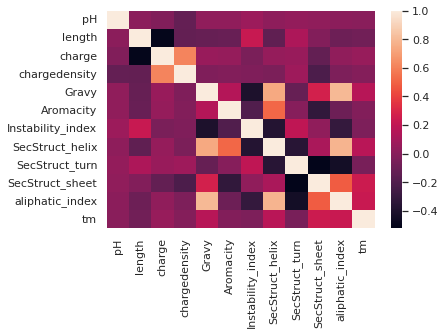

In [119]:
corr = data_scale.corr()
sn.heatmap(corr.iloc[1:,1:], annot=False)

Boxplots para cada variável continua

O objetivo é perceber se os valores são parecidos, se há outliers

In [120]:
------------------------------------------------------------------------------------------------------------------------------------------------------

SyntaxError: invalid syntax (258235334.py, line 1)

------------------------------------------------------------------------------------------------------------------------------------------------------

### Análise não supervisionada


* #### Divisão do dataset: X e Y

In [ ]:
#data_scale

In [ ]:
#separar X e Y 
X = data_scale.iloc[:, 1:-1]
Y = data_scale.iloc[:, -1]

In [ ]:
#visualizar
X.head()

,pH,length,charge,chargedensity,Gravy,Aromacity,Instability_index,SecStruct_helix,SecStruct_turn,SecStruct_sheet,aliphatic_index
0,0.050944,-0.278739,0.192039,0.041713,1.496181,-0.864209,-1.064756,0.459141,-0.341062,1.736920,1.233539
1,0.050944,-0.406481,-0.387246,-0.957675,-2.382684,-1.523549,2.169647,-1.860071,-1.488109,2.051137,-0.915022
2,0.050944,0.083584,0.902139,0.828932,-1.194683,-0.001893,-0.474614,-1.950464,0.946386,-1.123765,-2.152786
3,0.050944,-0.455255,-0.819847,-1.906825,-0.559893,-0.348875,0.883051,-0.634913,-0.250979,0.626853,-0.447528
4,0.050944,2.299329,-0.889222,-0.228271,-0.224447,-0.594790,0.457290,-0.553913,1.523183,-1.272651,-0.520198


------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#visualizar Y (neste momento é um panda series / array)
#print(Y)

#converter Y para pandas dataframe, pois por vezes é mais fácil utilizar este formato
data_Y = Y.to_frame(name = "Y")
data_Y.head()

,Y
0,1.918961
1,0.083704
2,-0.644573
3,-0.156628
4,0.010876


------------------------------------------------------------------------------------------------------------------------------------------------------

Analisar os valores de tm, de forma a criar, a partir dessa, uma outra variável, mas desta vez categórica / qualitativa classificando em "tm baixo" ou "tm alto" consoante os valores de tm

                  Y
count  2.873900e+04
mean  -4.747006e-16
std    1.000017e+00
min   -3.594094e+00
25%   -5.134831e-01
50%   -9.836538e-02
75%    3.021868e-01
max    5.873504e+00


<AxesSubplot: >

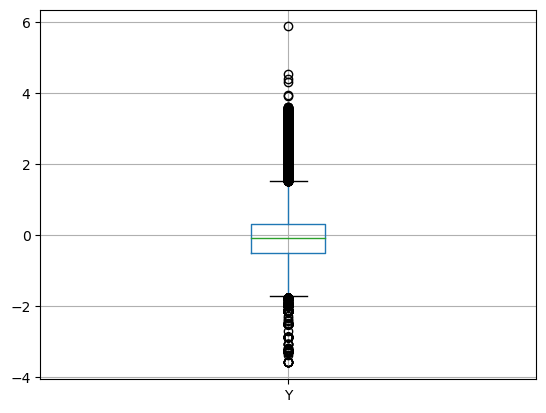

In [ ]:
summary = data_Y.describe() #data_Y é pandas dataframe
print(summary)
data_Y.boxplot()

Y categorico

In [ ]:
Y_categorical = Y.copy() #copia para não alterar Y (nota Y é array)
mean = Y_categorical.mean()
median = Y_categorical.median()

#criar variavel categorica dividindo os valores de tm de acordo com média

Y_categorical[Y_categorical > mean] = "elevado"
Y_categorical[Y_categorical != "elevado"] = "baixo"

Y_categorical #Y_categorical é array / panda series

0        elevado
1        elevado
2          baixo
3          baixo
4        elevado
          ...   
28734    elevado
28735      baixo
28736    elevado
28737    elevado
28738      baixo
Name: tm, Length: 28739, dtype: object

In [ ]:
#converter o array / panda series em pandas dataframe 

data_Y_categorical = Y_categorical.to_frame(name = "Y_categorical")
data_Y_categorical

#frequencia de cada categoria
print('Frequência de cada categoria:\n')
data_Y_categorical.groupby("Y_categorical").size()

Frequência de cada categoria:



Y_categorical
baixo      16341
elevado    12398
dtype: int64

------------------------------------------------------------------------------------------------------------------------------------------------------

Clustering hierárquico

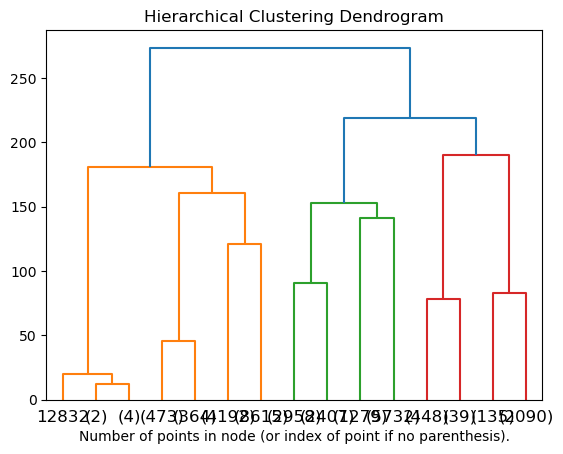

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



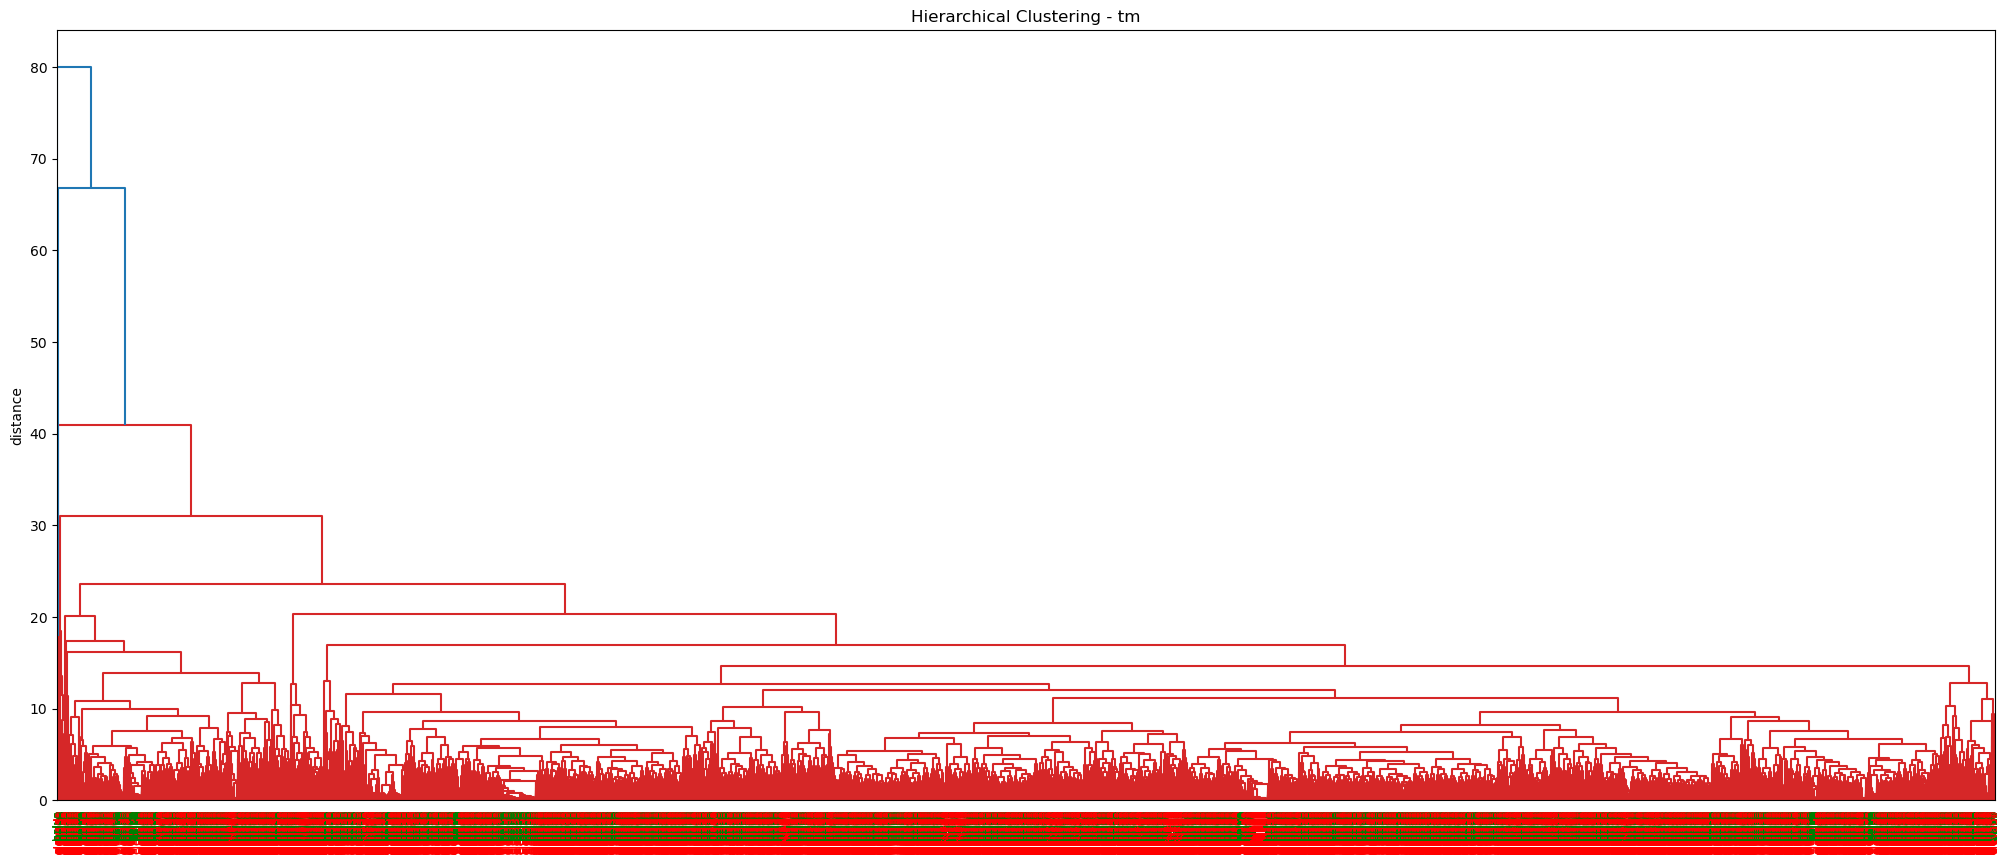

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='complete', metric='euclidean')

# calcula o dendograma
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(data_Y_categorical["Y_categorical"]),
    leaf_rotation=90.,  # rotação eixo x
    leaf_font_size=8.,  # tamanho letra eixo x
)

plt.title('Hierarchical Clustering - tm')
plt.ylabel('distance')


# Cores para os labels
label_colors = {'elevado': 'r', 'baixo': 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------

* #### Clustering aglomerativo

Procedemos à analise do clustering aglomerativo, tendo em conta as inferências obtidas no dendograma anterior. Considerámos um número de clusters igual a 2 e a 4. Os resultados espelham a dificuldade em agrupar clusters de acordo com a variável dependente (categórica).


In [ ]:
hclust = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
hclust.fit(X)
res_hc = hclust.labels_
pd.crosstab(data_Y_categorical["Y_categorical"], res_hc)

col_0,0,1
Y_categorical,,
baixo,9250,7091
elevado,5838,6560


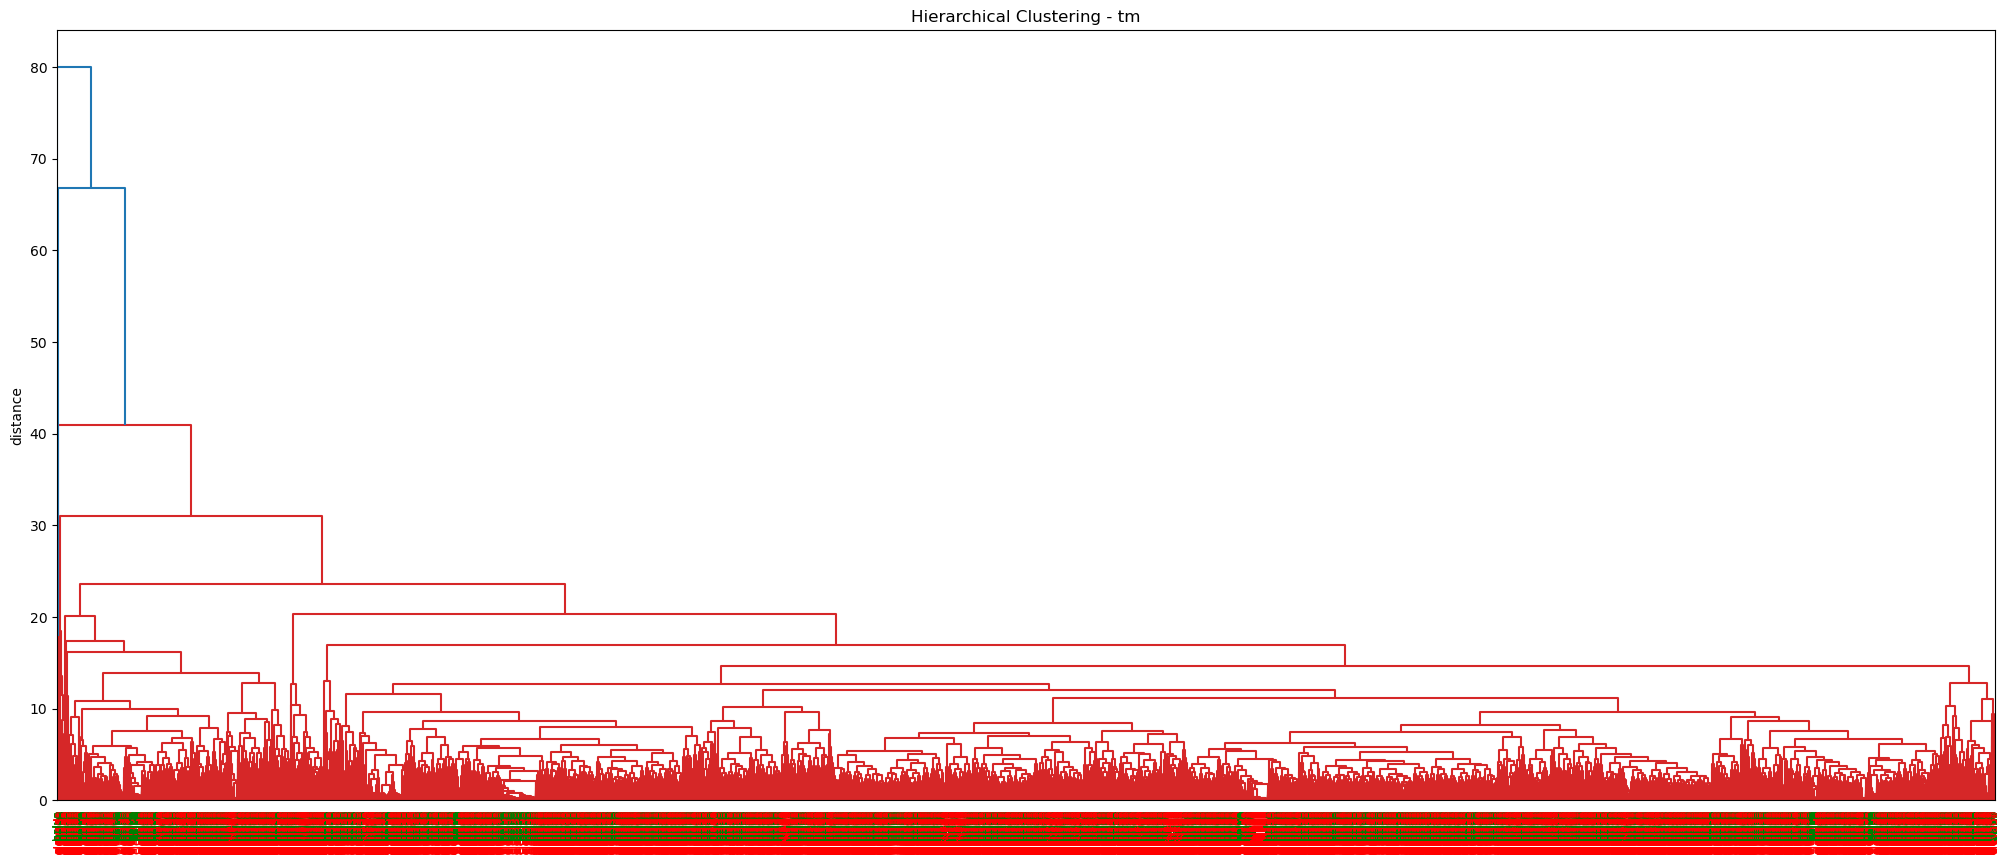

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='complete', metric='euclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(data_Y_categorical["Y_categorical"]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering - tm')
plt.ylabel('distance')


# Assignment of colors to labels: 'a' is red, 'b' is green, etc.
label_colors = {'elevado': 'r', 'baixo': 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()


Clustering kmeans

# Dá me erro 

In [ ]:
from sklearn.cluster import KMeans
k=2

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["Y_categorical"], rownames=['clusters'] )

[0 1 1 ... 1 0 0]
[[-0.015 -0.162  0.066 -0.024  0.358  0.115 -0.291  0.389 -0.253  0.165
   0.386]
 [ 0.042  0.446 -0.181  0.066 -0.986 -0.316  0.801 -1.071  0.696 -0.453
  -1.063]]


Y_categorical,baixo,elevado
clusters,,
0,11617,9480
1,4724,2918


In [ ]:
from sklearn.cluster import KMeans
k=4

kmeans_dataset = KMeans(n_clusters=k, max_iter=1000)
kmeans_dataset.fit(X)
kmeans_dataset.predict(X)

labels = kmeans_dataset.labels_
print(labels)

centroids = kmeans_dataset.cluster_centers_
print(centroids)

pd.crosstab(labels,data_Y_categorical["Y_categorical"], rownames=['clusters'] )


[1 2 2 ... 3 3 1]
[[-0.027  2.004 -2.12  -1.008 -0.711 -0.491  0.627 -0.66  -0.004  0.249
  -0.451]
 [ 0.125 -0.185  0.004 -0.207  0.708 -0.406 -0.224  0.461 -0.463  0.796
   0.891]
 [ 0.035  0.134  0.479  0.582 -1.259 -0.615  1.192 -1.523  1.102 -0.589
  -1.365]
 [-0.099 -0.207  0.18   0.138 -0.051  0.555 -0.276  0.202  0.024 -0.457
  -0.195]]


Y_categorical,baixo,elevado
clusters,,
0,1408,595
1,4746,5024
2,2191,1648
3,7996,5131


------------------------------------------------------------------------------------------------------------------------------------------------------

PCA

Var. explicada: [0.29  0.184]
Soma: 47.465288903257054 %



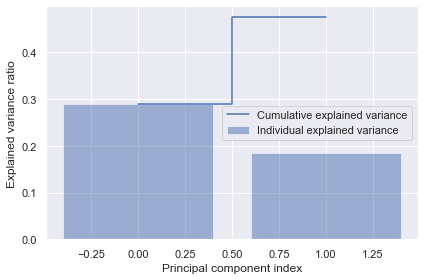

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(n_components=2) #experimentar diferentes valores de n_components
pca.fit(X)

X_r = pca.transform(X) # transformacao dos dados no novo espaço utilizando apenas n CP

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

print()

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

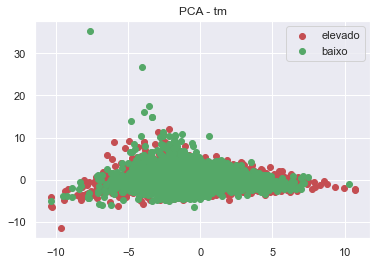

In [ ]:
meta_values = data_Y_categorical["Y_categorical"]
plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(X_r[meta_values == name, 0], X_r[meta_values == name, 1], c=c, label=name)
plt.legend()
plt.title('PCA - tm')
plt.show()


Considerando dois componentes principais, apenas é explicada cerca de 50% da variabilidade do dataset. Neste caso, observa-se ainda marcada sobreposição / similaridade das duas categorias (tm alto / baixo) da variável dependente.

Uma vez que pretendiamos um número de componentes principais que explicasse pelo menos 95% da variabilidade do dataset, fizemos um gráfico que nos permitisse inferir esse valor.


In [ ]:
pca = PCA().fit(X)

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 23, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)

ax.grid(axis='x')
plt.tight_layout()
plt.savefig('pcavisualize_1.png', dpi=300)
plt.show()

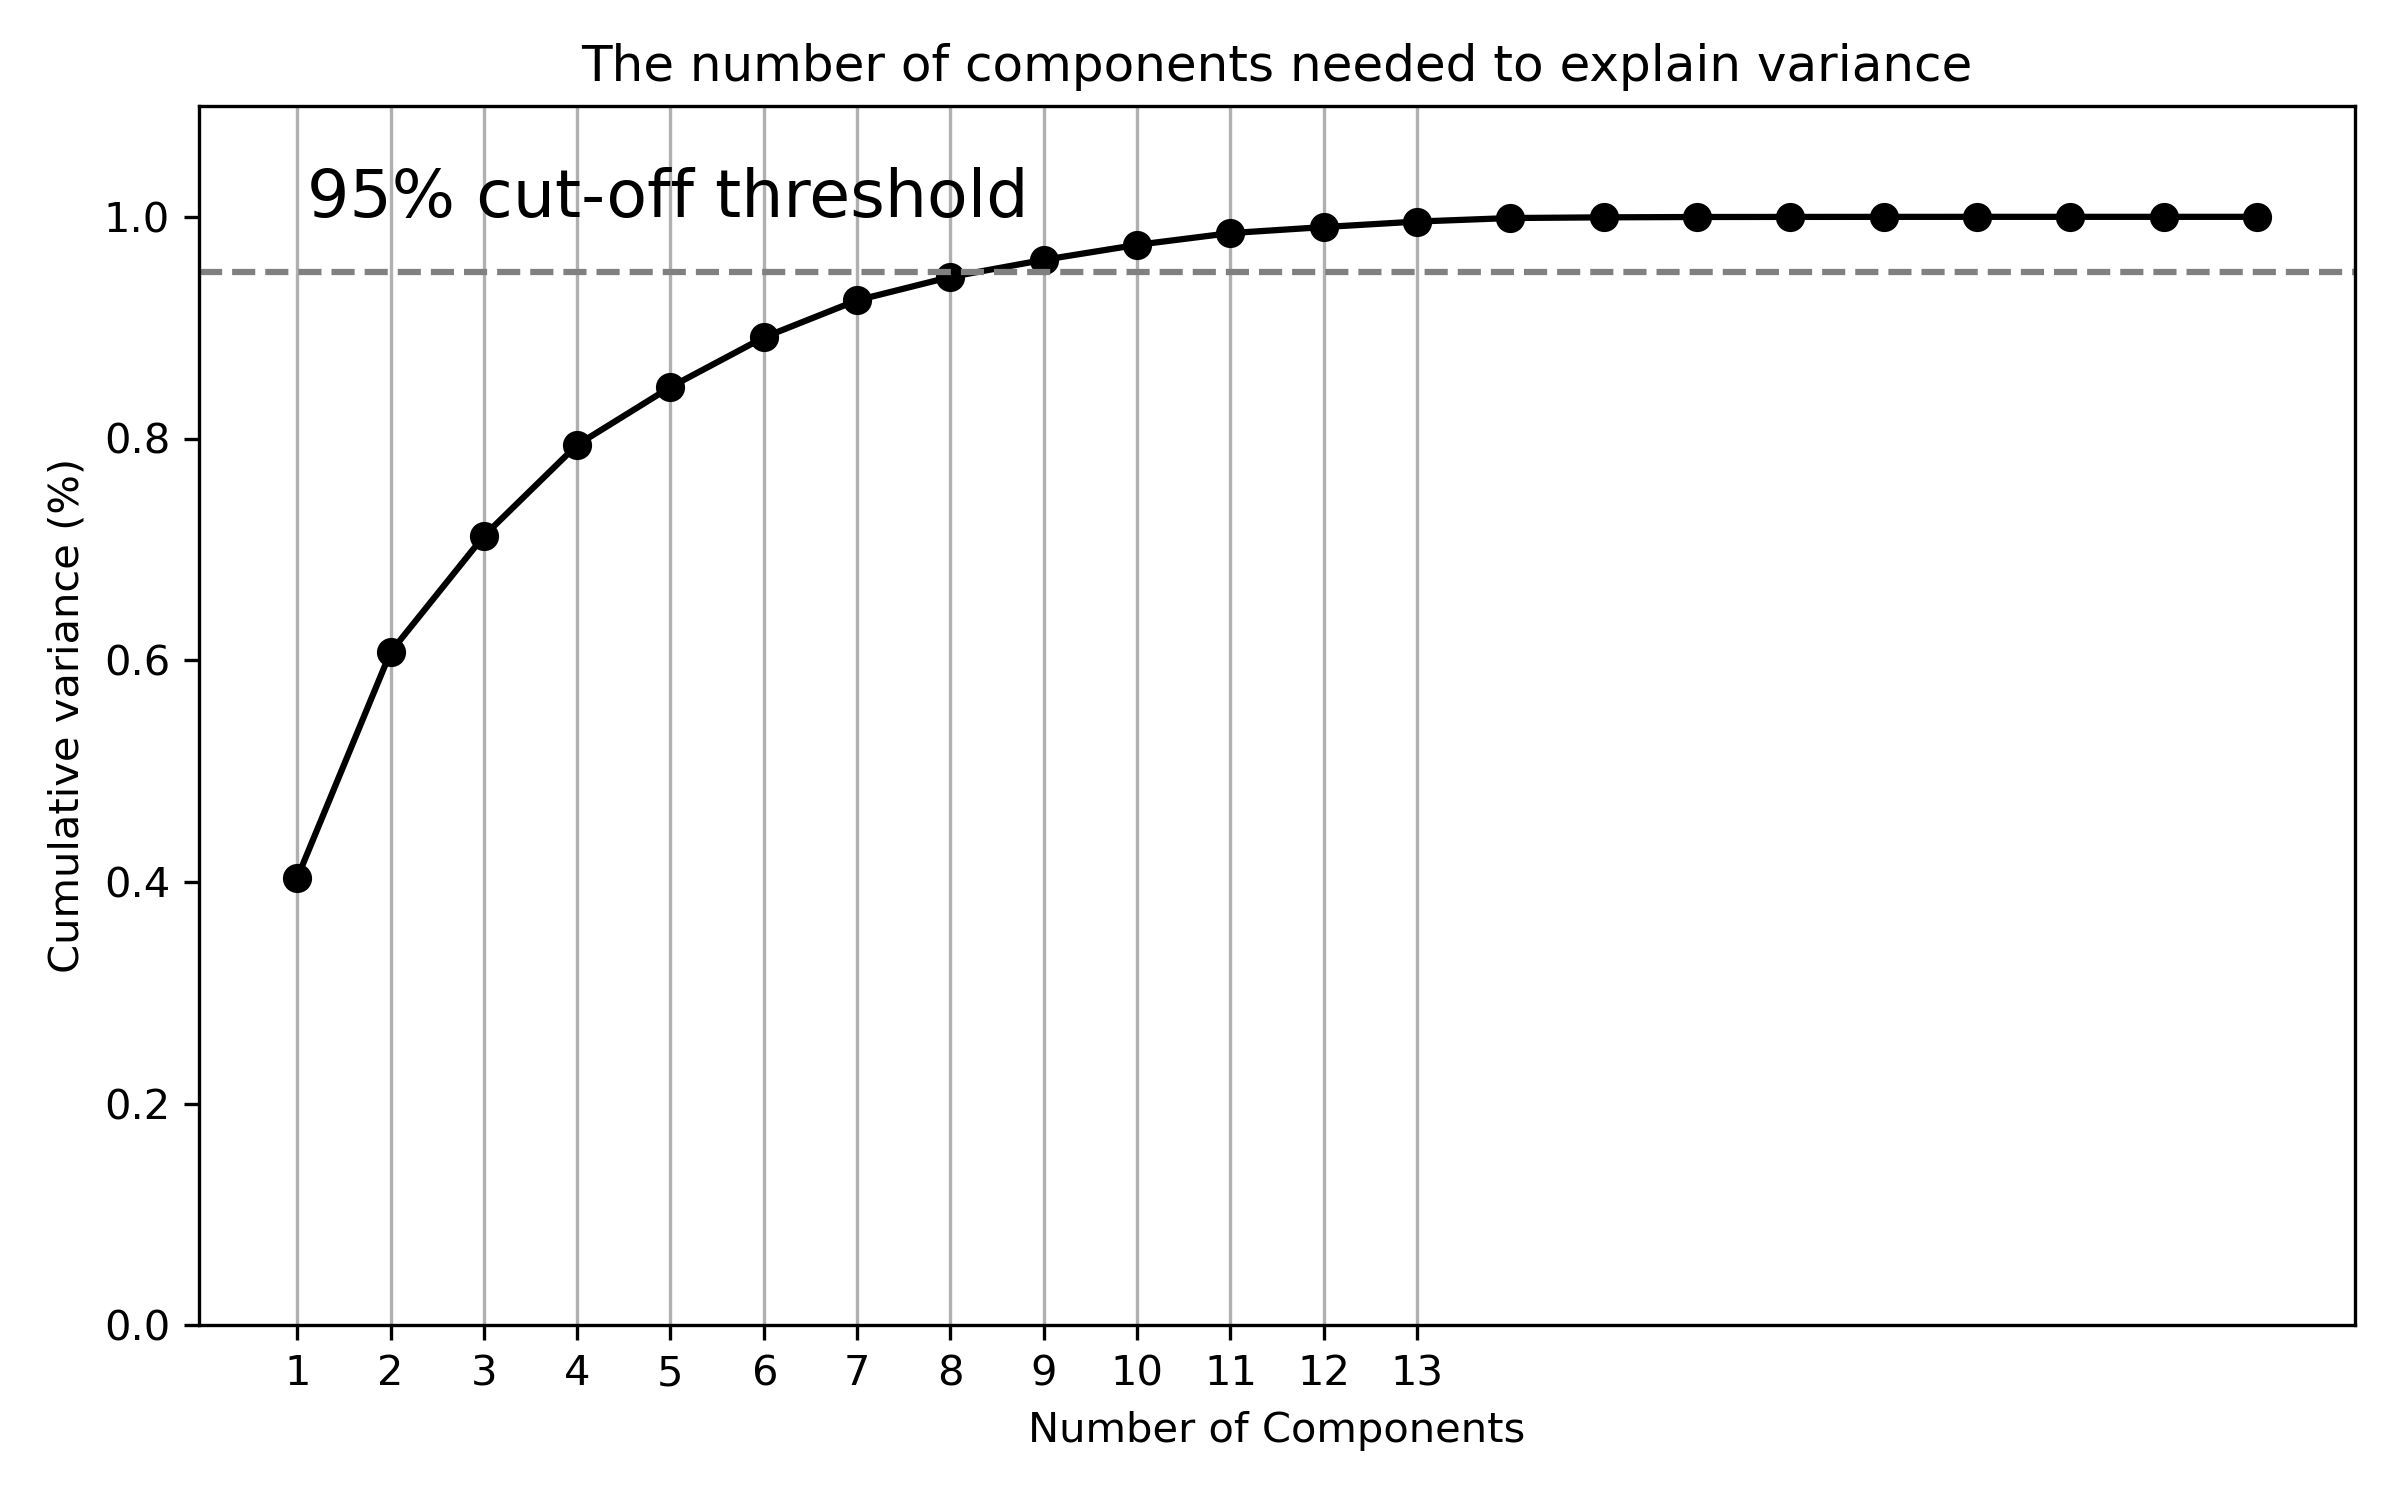


Assim, concluimos ser possível prever uma variabilidade do dataset superior a 95% ao somar as variâncias cumulativas esperadas de oito componentes principais.

Tal como esperado, o aumento do número de componentes principais conduz a uma maior soma cumulativa das variâncias esperadas. Se pretendessemos reduzir a dimensionalidade do dataset, poderiamos usar apenas esses componentes nas análises seguintes e, num processo iterativo, verificar se seriam obtidos resultados melhores.


In [ ]:
pca = PCA(n_components=8)
pca.fit(X)

X_r = pca.transform(X) #

print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, "%")

Var. explicada: [0.29  0.184 0.139 0.094 0.09  0.073 0.062 0.033]
Soma: 96.52637164900989 %


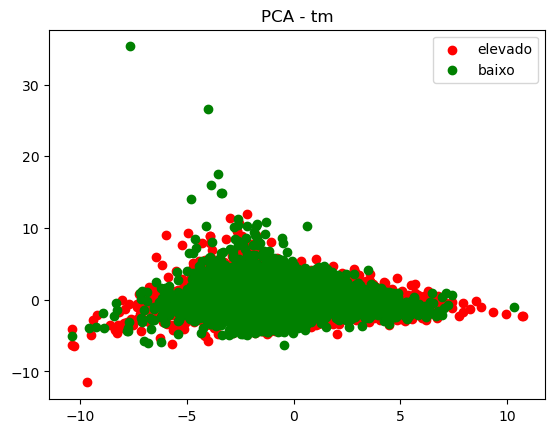

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------

TSNE

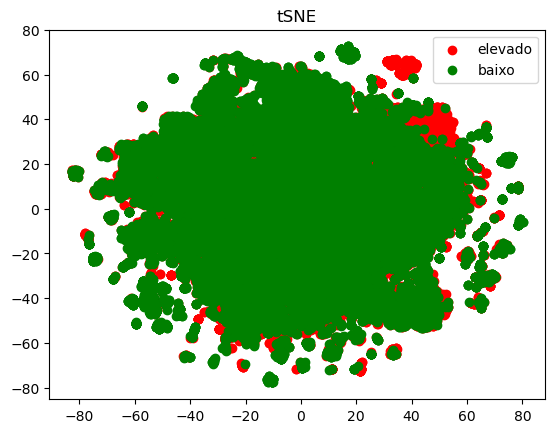

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=1000)
points = tsne.fit_transform(X)
meta_values = data_Y_categorical["Y_categorical"]

plt.figure()
for c, name in zip("rgb", ["elevado", "baixo"]):
    plt.scatter(points[meta_values == name, 0], points[meta_values == name, 1], c=c, label=name)
plt.title("tSNE")
plt.legend(loc='best', shadow=False)
plt.show()


------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------

# Machine Learning

In [ ]:
data_Y_categorical

A partir deste momento, o nosso y é uma variavel binaria em que 0 representa um tm baixo em relação à média e 1 reprensenta um tm elevado em relação à média.

In [ ]:
data_y = data_Y_categorical.replace(['baixo', 'elevado'], [0, 1])
data_y

,Y_categorical
0,1
1,1
2,0
3,0
4,1
...,...
28734,1
28735,0
28736,1
28737,1


Existem 16 341 valores de tm inferiores à média e 12 398 valores de tm superiores à média

In [ ]:
data_y.groupby("Y_categorical").size()

Y_categorical
0    16341
1    12398
dtype: int64

Dividir os dados em treino e em teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, data_y, test_size = 0.25, random_state = 500)


print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (21554, 11) (21554, 1)
Test:  (7185, 11) (7185, 1)


Regressão e curva roc

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

C:\Users\sonia\anaconda3\envs\SIB\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
def score_test_set(model, X_test, y_test):
    # score test set
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)
    except:
        y_prob = None
    print('accuracy', accuracy_score(y_test, y_pred))
    print('MCC', matthews_corrcoef(y_test, y_pred))
    print('f1 score', f1_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('fdr', float(fp) / (tp + fp))
    print('sn', float(tp) / (tp + fn))
    print('sp', float(tn) / (tn + fp))

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
score_test_set(model, X_test, y_test)
# ROC_AUC
# prediction = model.predict_proba(X_test)

preds = model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'g', label='AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('ROC AUC score:', round(roc_auc, 4))

##### --> Regressão Logística e curva ROC:

Obtivemos um f1-score de 0.72 para termoestabilidade baixa, e 0.40 para elevada. 

A área sob a curva AUC resume a performance do modelo;
A forma da curva mostra a taxa de falsos positivos esperada e a taxa de falsos negativos; É apropriada quando as observações são balanceadas entre as classes.

Quanto menores os valores no eixo x indica menos falsos positivos e mais verdadeiros negativos.
Quanto maiores os valores no eixo y indica mais verdadeiros positivos e menos falsos negativos.

Neste caso, os valores estão mais próximos do eixo y, mostrando assim que temos mais valores Verdadeiros Positivos do que Falsos Negativos.

------------------------------------------------------------------------------------------------------------------------------------------------------

Comparar os modelos com e sem pesos

Como as proporções entre as 2 categorias de y são diferentes, os pesos vão ser diferentes também.
Assim, para a categoria '0' que tem 16 341, a proporção vai ser de 0.75, enquanto que para a categoria '1' que tem 12 398, a porpoção vai ser 1.

In [ ]:
#Test and compare multiple models

models = [('LR', LogisticRegression()),
          ('LR-W', LogisticRegression(class_weight={0: 0.75, 1: 1})),
          ('RF', RandomForestClassifier()),
          ('RF-W', RandomForestClassifier(class_weight={0: 0.75, 1: 1})),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()),
          ('SVM-W', SVC(class_weight={0: 0.75, 1: 1})),
          ('DT', DecisionTreeClassifier()),
          ('DT-W', DecisionTreeClassifier(class_weight={0: 0.75, 1: 1}))]


names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cross_val = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    results.append(cross_val)
    names.append(name)
    msg = "%s: %f SD:%f" % (name, cross_val.mean(), cross_val.std())
    print(msg)


plot dos resultados -- all models

In [ ]:
# Plot the results
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Os valores de cross val vão de 0.0 a 1.0, onde quanto mais próximo de 1.0, melhor.
Neste caso podemos observar que os melhores modelos paratreinar os dados são: 

    - Regressão logistica com pesos
    - Random Forest com e sem pesos
    - KNN
    - SVM com pesos
    - Decision trees com e sem pesos
    


In [ ]:
columns = X.columns
columns

SVM

In [ ]:
param_grid = {'C': [0.01,0.1,1],
#               'C': [0.1, 1, 10]
              'kernel': ['linear']}

#hyperparameter optimization algorithm
grid = GridSearchCV(SVC(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)


#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)


#feature importance
pd.Series(abs(grid.best_estimator_.coef_[0]), index=columns).nlargest(20).plot(kind='barh')


No SVM podemos ver que os melhores parâmetros foram : {'C': 1, 'kernel': 'linear'}

Apresenta uma accuracy de:  0.61

Apresenta um f1 score de: 0.22

Pela matriz de confusao podemos ver que existe um elevado número de Falsos Positivos (2651).

------------------------------------------------------------------------------------------------------------------------------------------------------

Regressão logistica sem peso com RandomizedSearchCV

In [ ]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=0)

distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

clf = RandomizedSearchCV(logistic, distributions, random_state=0)
clf
search = clf.fit(X_train, y_train)
search.best_params_

score_test_set(search, X_test, y_test)

pd.Series(abs(search.best_estimator_.coef_[0]), index=columns).nlargest(20).plot(kind='barh')

No LR com RandomizedSearch podemos ver que:

Apresenta uma accuracy de:  0.61

Apresenta um f1 score de: 0.39

Pela matriz de confusao podemos ver que existe um elevado número de Falsos Positivos (2143).

------------------------------------------------------------------------------------------------------------------------------------------------------

RandomForest sem pesos com RandomizedSearchCV¶

In [ ]:
param_grid = {'n_estimators': [10, 100, 200]}

#hyperparameter optimization algorithm
grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, refit = True, verbose = 3)
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)
#SCORE THE TEST SET
score_test_set(grid, X_test, y_test)

# feature importance for RF
pd.Series(abs(grid.best_estimator_.feature_importances_), index= columns).nlargest(20).plot(kind='barh')

Feature selection

Select Percentile

In [ ]:
select = SelectPercentile(score_func = f_classif, percentile = 25)
select.fit(X_train, y_train)

train_x = select.transform(X_train)
test_x = select.transform(X_test)

model = LogisticRegression()

#cross validation
scores = cross_val_score(clf, train_x, y_train, cv=5)
print('Scores: ', scores)

Apresenta uma accuracy de:  0.67

Apresenta um f1 score de: 0.56

Pela matriz de confusao podemos ver que existe um número menor de Falsos Positivos (1511).

Variance Threshold

In [ ]:
------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------